In [ ]:
import sys
import warnings
!pip install yfinance
import yfinance as yf
# install tensorflow 1.15 dengan cara pip install tensorflow==1.15
if not sys.warnoptions:
    warnings.simplefilter('ignore')

Deklarasi Library


In [ ]:
%tensorflow_version 1.15
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Pemanggilan Data Set

In [ ]:
df = yf.download("PAMG.JK", start="2020-02-11", end="2021-02-15")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.reset_index()

tf.compat.v1.disable_eager_execution()
# df = pd.read_csv('AAPLCUT.csv')
df.head (243)


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
0,2020-02-11,116.0,125.0,107.0,120.0,13394300
1,2020-02-12,122.0,131.0,114.0,123.0,27121000
2,2020-02-13,124.0,124.0,112.0,114.0,5203300
3,2020-02-14,115.0,140.0,112.0,140.0,22206800
4,2020-02-17,142.0,152.0,127.0,151.0,25587000
...,...,...,...,...,...,...
238,2021-02-05,93.0,103.0,90.0,92.0,13371000
239,2021-02-08,93.0,93.0,90.0,91.0,1829600
240,2021-02-09,91.0,94.0,90.0,92.0,2033300
241,2021-02-10,93.0,93.0,88.0,91.0,1525100


Grafik Data saham periode 1 tahun

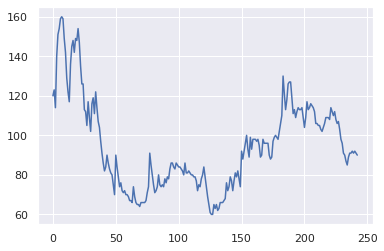

In [ ]:
y= df['Close']
y.index=df.index
y.plot()

Proses Normalisasi

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log .head



<bound method NDFrame.head of         0
0    0.60
1    0.63
2    0.54
3    0.80
4    0.91
..    ...
238  0.32
239  0.31
240  0.32
241  0.31
242  0.30

[243 rows x 1 columns]>

Inisialisasi Parameter


In [ ]:
simulation_size = 1
num_layers = 1
size_layer = 64
timestamp = 5
epoch = 1000
dropout_rate = 0.8
test_size = 5
learning_rate = 0.001

df_train = df_log
df.shape, df_train.shape

((243, 6), (243, 1))

Membuat Model dengen RNN

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
 
        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100
 
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.compat.v1.Session()   
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8))
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s, acc=96.5, cost=0.00274]


In [ ]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori [-5:]  = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()


In [ ]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

1

In [ ]:
Result = pd.DataFrame({'Predict1' : accepted_results[0]})


Model Memprediksi

In [ ]:
for i in range(len(df['Close'])):
  print('Original :', df['Close'][i], '| ', 'Predict 1:', np.round(Result['Predict1'][i], 2))

Original : 120.0 |  Predict 1: 120.0
Original : 123.0 |  Predict 1: 122.63
Original : 114.0 |  Predict 1: 117.75
Original : 140.0 |  Predict 1: 130.46
Original : 151.0 |  Predict 1: 145.19
Original : 154.0 |  Predict 1: 149.04
Original : 159.0 |  Predict 1: 151.11
Original : 160.0 |  Predict 1: 151.81
Original : 159.0 |  Predict 1: 153.97
Original : 149.0 |  Predict 1: 153.55
Original : 142.0 |  Predict 1: 150.12
Original : 129.0 |  Predict 1: 138.39
Original : 122.0 |  Predict 1: 136.9
Original : 117.0 |  Predict 1: 127.23
Original : 136.0 |  Predict 1: 125.92
Original : 145.0 |  Predict 1: 132.7
Original : 148.0 |  Predict 1: 139.0
Original : 142.0 |  Predict 1: 141.31
Original : 149.0 |  Predict 1: 141.82
Original : 148.0 |  Predict 1: 139.55
Original : 154.0 |  Predict 1: 146.33
Original : 147.0 |  Predict 1: 142.6
Original : 135.0 |  Predict 1: 142.94
Original : 126.0 |  Predict 1: 131.97
Original : 126.0 |  Predict 1: 127.3
Original : 113.0 |  Predict 1: 121.49
Original : 112.0 |

Akurasi dan Grafik Prediksi

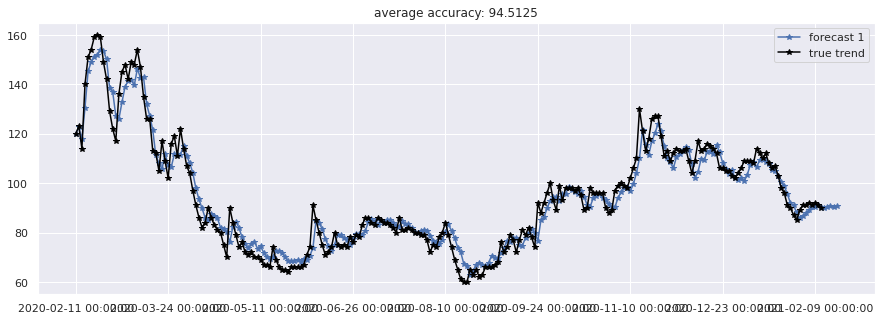

In [ ]:
from sklearn.metrics import mean_squared_error
import math
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]
rmse = [mean_squared_error(df['Close'].values, r[:-test_size], squared=False) for r in accepted_results]
mse = [mean_squared_error(df['Close'].values, r[:-test_size], squared=True) for r in accepted_results]
rse = math.sqrt(np.mean(mse)/(df_train.shape[0]-2))
plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1), marker = '*')
plt.plot(df['Close'], label = 'true trend', c = 'black', marker = '*')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])
#print("RMSE : % 2d, MSE : % 5.2f, RSE : %5.2f" %(np.mean(rmse), np.mean(mse), rse)) 
plt.show()

In [ ]:
Result = pd.DataFrame({'Predict1' : accepted_results[0]})

In [ ]:
Result 

,Predict1
0,119.999996
1,122.634164
2,117.748091
3,130.461314
4,145.187200
...,...
243,90.119489
244,90.508863
245,90.710923
246,90.150090


Prediksi 5 hari

In [ ]:
import pandas as pd
hasil = pd.read_csv('output.csv',sep=',', error_bad_lines = False)
hasil = hasil[['Data Aktual','Data Prediksi']]

hasil 

,Data Aktual,Data Prediksi
0,90,90.119489
1,90,90.508863
2,89,90.710923
3,92,90.150090
4,91,90.786662


Penghitungan Error

In [ ]:
y=hasil['Data Prediksi']
yhat= hasil['Data Aktual']
x = list(range(len(y)))
d = y - yhat
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)

print("Nilai Error:")
print("MAE:",mae_f)


Nilai Error:
MAE: 0.8805046000000004


In [ ]:
print("MSE:", mse_f)

MSE: 1.3336313592325932


In [ ]:
print("RMSE:", rmse_f)

RMSE: 1.15482958016869


# New Section